In [1]:
from transformers import AutoTokenizer, AutoModelForSequenceClassification
import torch
import csv
from tqdm import tqdm
import pandas as pd

In [46]:
# 加载文本分析工具
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")
# Load the model and tokenizer
model_name = "tabularisai/multilingual-sentiment-analysis"
tokenizer = AutoTokenizer.from_pretrained(model_name)
model = AutoModelForSequenceClassification.from_pretrained(model_name)
model.to(device)
model.eval()

Using device: cuda


DistilBertForSequenceClassification(
  (distilbert): DistilBertModel(
    (embeddings): Embeddings(
      (word_embeddings): Embedding(119547, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (transformer): Transformer(
      (layer): ModuleList(
        (0-5): 6 x TransformerBlock(
          (attention): DistilBertSdpaAttention(
            (dropout): Dropout(p=0.1, inplace=False)
            (q_lin): Linear(in_features=768, out_features=768, bias=True)
            (k_lin): Linear(in_features=768, out_features=768, bias=True)
            (v_lin): Linear(in_features=768, out_features=768, bias=True)
            (out_lin): Linear(in_features=768, out_features=768, bias=True)
          )
          (sa_layer_norm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
          (ffn): FFN(
            (dropout): Dropout(p=0.1, inplace=False)

In [47]:
#load dataset
reviews_path = '../city_filter/reviews_Indianapolis.csv'

In [48]:
def batch_slide_window_sentiment(text_list, window_size=512, step_size=256):
    """
    对一个文本列表进行滑动窗口情感分析，每个文本由多个窗口组成，最终平均得出整体情感。
    """
    sentiment_map = {
        0: 'Very Negative',
        1: 'Negative',
        2: 'Neutral',
        3: 'Positive',
        4: 'Very Positive'
    }

    all_chunks = []
    chunk_mapping = []  # [(start_idx_in_all_chunks, num_chunks)]，每条原始文本映射

    for text in text_list:
        tokens = tokenizer.encode(text, add_special_tokens=False)
        chunks = []

        if len(tokens) <= window_size:
            chunks.append(text)
        else:
            for i in range(0, len(tokens), step_size):
                chunk = tokens[i:i + window_size]
                if chunk:
                    chunks.append(tokenizer.decode(chunk))
            # 确保最后一个 chunk 包含尾部
            if tokenizer.decode(tokens[-window_size:]) not in chunks:
                chunks.append(tokenizer.decode(tokens[-window_size:]))

        start = len(all_chunks)
        all_chunks.extend(chunks)
        chunk_mapping.append((start, len(chunks)))

    # Tokenize and move to device
    inputs = tokenizer(all_chunks, return_tensors="pt", truncation=True, padding=True, max_length=512)
    inputs = {k: v.to(device) for k, v in inputs.items()}

    with torch.no_grad():
        outputs = model(**inputs)
        probs = torch.nn.functional.softmax(outputs.logits, dim=-1)

    # Aggregate results per original text
    results = []
    for start, count in chunk_mapping:
        chunks_probs = probs[start:start + count]
        avg_prob = torch.mean(chunks_probs, dim=0)
        label = torch.argmax(avg_prob).item()
        results.append(sentiment_map[label])

    return results

In [35]:
try_path = '../yelp_reviews_first100.csv'

In [55]:
# 分析评论
def analyze_reviews_with_sentiment(input_csv_path, output_csv_path, batch_size=32):
    """
    从CSV中读取'review'文本，进行批量情感分析，将结果写入新CSV。
    原 'text' 字段会被情感标签替代。
    """
    with open(input_csv_path, 'r', encoding='utf-8') as infile, \
         open(output_csv_path, 'w', encoding='utf-8', newline='') as outfile:

        reader = csv.DictReader(infile)
        fieldnames = reader.fieldnames
        writer = csv.DictWriter(outfile, fieldnames=fieldnames)
        writer.writeheader()

        batch_rows = []
        batch_texts = []

        for row in tqdm(reader, desc="Analyzing", total=361701):
            batch_rows.append(row)
            batch_texts.append(row['text'])

            if len(batch_rows) >= batch_size:
                sentiments = batch_slide_window_sentiment(batch_texts)
                for r, s in zip(batch_rows, sentiments):
                    r['text'] = s
                    writer.writerow(r)
                batch_rows = []
                batch_texts = []

        # 写入最后不足一个 batch 的数据
        if batch_rows:
            sentiments = batch_slide_window_sentiment(batch_texts)
            for r, s in zip(batch_rows, sentiments):
                r['text'] = s
                writer.writerow(r)

    print(f"情感分析完成，结果保存至：{output_csv_path}")
            

In [56]:
output_path = "reviews_Indianapolis_analyzed.csv"
analyze_reviews_with_sentiment(reviews_path, output_path)

Analyzing: 100%|█████████▉| 361626/361701 [31:12<00:00, 193.12it/s]


情感分析完成，结果保存至：reviews_Indianapolis_analyzed.csv


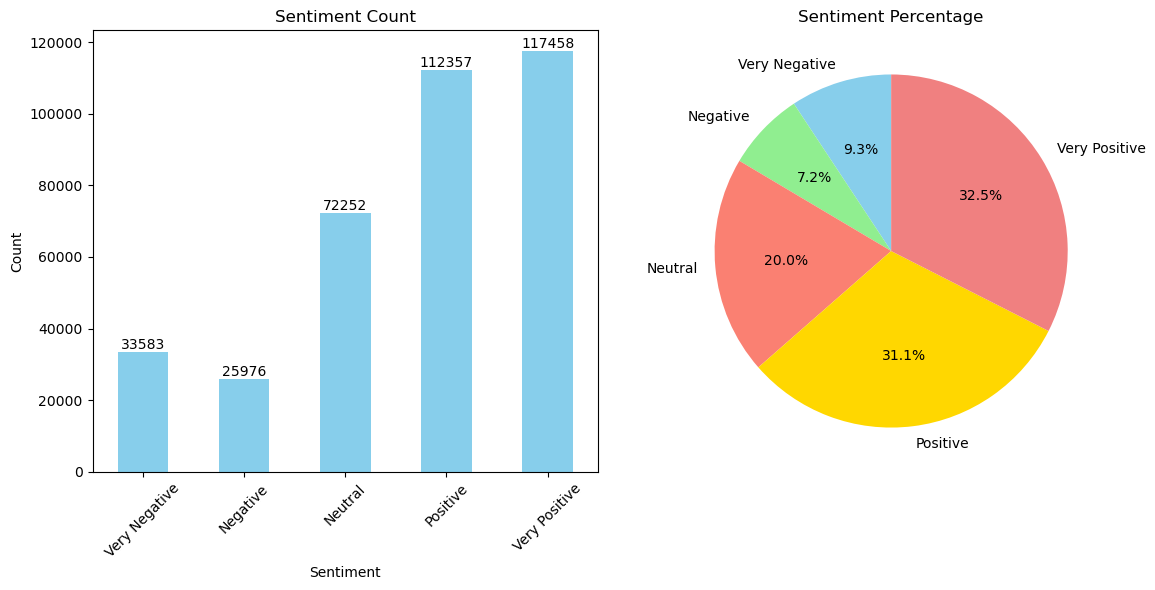

In [10]:
# 可视化各种情感分析的占比
output_path = "reviews_Indianapolis_analyzed.csv"
from matplotlib import pyplot as plt
import pandas as pd
def visualize_sentiment_distribution(input_csv_path):
    """
    可视化情感分析结果的分布。使用subplot,并列展示柱状图和饼状图
    """
    df = pd.read_csv(input_csv_path)
    sentiment_counts = df['text'].value_counts()

    sentiment_counts = sentiment_counts.reindex(['Very Negative', 'Negative', 'Neutral', 'Positive', 'Very Positive'], fill_value=0)
    sentiment_counts.index = ['Very Negative', 'Negative', 'Neutral', 'Positive', 'Very Positive']
    # sentiment_counts = sentiment_counts.sort_index()
    sentiment_counts.index.name = 'Sentiment'
    sentiment_counts.name = 'Count'
    sentiment_counts = sentiment_counts.reset_index()
    sentiment_counts['Percentage'] = sentiment_counts['Count'] / sentiment_counts['Count'].sum() * 100
    sentiment_counts['Percentage'] = sentiment_counts['Percentage'].round(2)
    sentiment_counts = sentiment_counts.set_index('Sentiment')
    # sentiment_counts = sentiment_counts.sort_index()
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 6))
    sentiment_counts['Count'].plot(kind='bar', ax=ax1, color='skyblue')
    ax1.set_title('Sentiment Count')
    ax1.set_xlabel('Sentiment')
    ax1.set_xticklabels(sentiment_counts.index, rotation=45)
    # 在每个柱上面标注数据
    for i, v in enumerate(sentiment_counts['Count']):
        ax1.text(i, v + 0.5, str(v), ha='center', va='bottom')
    ax1.set_ylabel('Count')
    sentiment_counts['Percentage'].plot(kind='pie', ax=ax2, autopct='%1.1f%%', startangle=90, colors=['skyblue', 'lightgreen', 'salmon', 'gold', 'lightcoral'])
    ax2.set_title('Sentiment Percentage')
    ax2.set_ylabel('')
    plt.tight_layout()
    plt.savefig('sentiment_distribution.png')
    plt.show()

visualize_sentiment_distribution(output_path)